# CIFAR10 Batch Norm classifier 

In [1]:
# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Download Input data set and Apply summary statistics

In [3]:
train = datasets.CIFAR10('./data', train=True, download=True,  transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True,  transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [4]:
 train.data[0].shape

(32, 32, 3)

In [5]:
# train.transform(train.numpy()) # data[0][0].numpy()
data = train.data / 255 # data is numpy array

train_data_mean = data.mean(axis = (0,1,2)) 
train_data_std = data.std(axis = (0,1,2))
min = data.min(axis = (0,1,2))
max = data.max(axis = (0,1,2))
print(f"Mean : {train_data_mean}   STD: {train_data_std} Min:{min} Max:{max}",) #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]



Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784] Min:[0. 0. 0.] Max:[1. 1. 1.]


In [6]:
train_data_mean = (0.49139968, 0.48215841, 0.44653091)
train_data_std = (0.24703223, 0.24348513, 0.26158784)

In [7]:
train.data.shape

(50000, 32, 32, 3)

# Data Transformation
performed 2 basic transformations
1. ToTensor
2. Normalize

In [8]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(5),     #Rotates the image to a specified angel
    #transforms.ShiftScaleRotate(),
    #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std ), #(0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
    ])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std ), #(0.1307,), (0.3081,))
    ])

In [9]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders

In [10]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=8, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128, num_workers=8)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? False


# Display a sample Image from CIFAR10 dataset

In [11]:

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([96, 3, 32, 32])
torch.Size([96])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


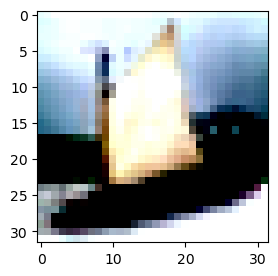

In [12]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
# Given a Tensor representing the image, use .permute() to put the channels as the last dimension
plt.imshow(images[0].permute(1,2,0),cmap='gray')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

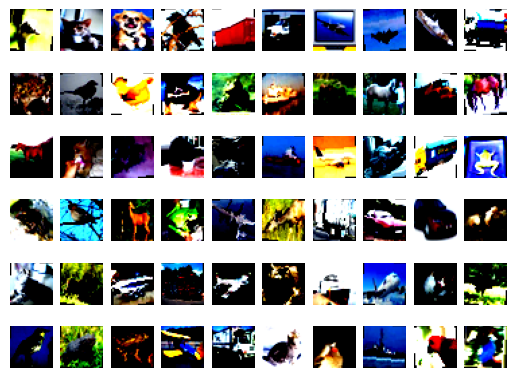

In [13]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].permute(1,2,0) , cmap='gray_r')

# Model Params

Can't emphasize on how important viewing Model Summary is. Unfortunately, there is no in-built model visualizer, so we have to take external help

In [14]:
!pip install torchsummary
from torchsummary import summary
from model import CIFAR10Net
use_cuda = torch.cuda.is_available()
device = torch.device(use_cuda if use_cuda else "cpu")
print(device)
model = CIFAR10Net(normType='BN').to(device)
summary(model, input_size=(3, 32, 32))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 24, 32, 32]           3,456
       BatchNorm2d-6           [-1, 24, 32, 32]              48
              ReLU-7           [-1, 24, 32, 32]               0
           Dropout-8           [-1, 24, 32, 32]               0
            Conv2d-9           [-1, 16, 34, 34]             384
      BatchNorm2d-10           [-1, 16, 34, 34]              32
             ReLU-11           [-1, 16, 34, 34]               0
        MaxPool2d-12           [-1, 16, 17, 17]               0
           Conv2d-13           [-1, 24, 17, 17]           3,456
      BatchNorm2d-14           [-1,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train and test Net model

In [15]:
from model import CIFAR10Net

device = torch.device("mps")
model =  CIFAR10Net(normType='BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.3439441919326782 Batch_id=390 Accuracy=36.58: 100%|███████████████| 391/391 [01:02<00:00,  6.21it/s]



Test set: Average loss: 2.3220, Accuracy: 2563/10000 (25.63%)

EPOCH: 1


Loss=1.2403000593185425 Batch_id=390 Accuracy=50.13: 100%|███████████████| 391/391 [01:01<00:00,  6.32it/s]



Test set: Average loss: 1.5088, Accuracy: 4605/10000 (46.05%)

EPOCH: 2


Loss=1.1711481809616089 Batch_id=390 Accuracy=55.53: 100%|███████████████| 391/391 [01:02<00:00,  6.25it/s]



Test set: Average loss: 1.3710, Accuracy: 5140/10000 (51.40%)

EPOCH: 3


Loss=1.116745948791504 Batch_id=390 Accuracy=59.60: 100%|████████████████| 391/391 [01:01<00:00,  6.36it/s]



Test set: Average loss: 1.2358, Accuracy: 5646/10000 (56.46%)

EPOCH: 4


Loss=1.3722599744796753 Batch_id=390 Accuracy=62.08: 100%|███████████████| 391/391 [01:01<00:00,  6.33it/s]



Test set: Average loss: 1.0806, Accuracy: 6201/10000 (62.01%)

EPOCH: 5


Loss=1.2248166799545288 Batch_id=390 Accuracy=64.05: 100%|███████████████| 391/391 [01:01<00:00,  6.33it/s]



Test set: Average loss: 1.0077, Accuracy: 6452/10000 (64.52%)

EPOCH: 6


Loss=1.0244978666305542 Batch_id=390 Accuracy=65.62: 100%|███████████████| 391/391 [01:01<00:00,  6.36it/s]



Test set: Average loss: 0.9431, Accuracy: 6720/10000 (67.20%)

EPOCH: 7


Loss=1.1489919424057007 Batch_id=390 Accuracy=66.47: 100%|███████████████| 391/391 [01:01<00:00,  6.35it/s]



Test set: Average loss: 0.9835, Accuracy: 6569/10000 (65.69%)

EPOCH: 8


Loss=0.8487651944160461 Batch_id=390 Accuracy=67.81: 100%|███████████████| 391/391 [01:01<00:00,  6.35it/s]



Test set: Average loss: 1.0178, Accuracy: 6456/10000 (64.56%)

EPOCH: 9


Loss=0.9516585469245911 Batch_id=390 Accuracy=68.63: 100%|███████████████| 391/391 [01:01<00:00,  6.36it/s]



Test set: Average loss: 0.9741, Accuracy: 6657/10000 (66.57%)

EPOCH: 10


Loss=0.8250374794006348 Batch_id=390 Accuracy=69.39: 100%|███████████████| 391/391 [01:02<00:00,  6.28it/s]



Test set: Average loss: 0.9210, Accuracy: 6805/10000 (68.05%)

EPOCH: 11


Loss=0.8330698013305664 Batch_id=390 Accuracy=70.21: 100%|███████████████| 391/391 [01:02<00:00,  6.30it/s]



Test set: Average loss: 0.8965, Accuracy: 6870/10000 (68.70%)

EPOCH: 12


Loss=0.8635794520378113 Batch_id=390 Accuracy=70.60: 100%|███████████████| 391/391 [01:02<00:00,  6.29it/s]



Test set: Average loss: 0.9205, Accuracy: 6759/10000 (67.59%)

EPOCH: 13


Loss=0.8194254040718079 Batch_id=390 Accuracy=71.27: 100%|███████████████| 391/391 [01:01<00:00,  6.39it/s]



Test set: Average loss: 0.9346, Accuracy: 6786/10000 (67.86%)

EPOCH: 14


Loss=0.8575912714004517 Batch_id=390 Accuracy=71.89: 100%|███████████████| 391/391 [01:01<00:00,  6.35it/s]



Test set: Average loss: 0.8209, Accuracy: 7135/10000 (71.35%)

EPOCH: 15


Loss=0.787072479724884 Batch_id=390 Accuracy=72.28: 100%|████████████████| 391/391 [01:01<00:00,  6.39it/s]



Test set: Average loss: 0.8591, Accuracy: 7054/10000 (70.54%)

EPOCH: 16


Loss=0.7424243092536926 Batch_id=390 Accuracy=72.67: 100%|███████████████| 391/391 [01:01<00:00,  6.39it/s]



Test set: Average loss: 0.8439, Accuracy: 7114/10000 (71.14%)

EPOCH: 17


Loss=0.8178116083145142 Batch_id=390 Accuracy=72.90: 100%|███████████████| 391/391 [01:01<00:00,  6.33it/s]



Test set: Average loss: 0.7988, Accuracy: 7230/10000 (72.30%)

EPOCH: 18


Loss=0.8675169944763184 Batch_id=390 Accuracy=73.15: 100%|███████████████| 391/391 [01:01<00:00,  6.39it/s]



Test set: Average loss: 0.7813, Accuracy: 7253/10000 (72.53%)

EPOCH: 19


Loss=0.8356756567955017 Batch_id=390 Accuracy=73.39: 100%|███████████████| 391/391 [01:02<00:00,  6.30it/s]



Test set: Average loss: 0.7349, Accuracy: 7449/10000 (74.49%)



# Train Vs Test Loss Plot

Text(0.5, 1.0, 'Test Accuracy')

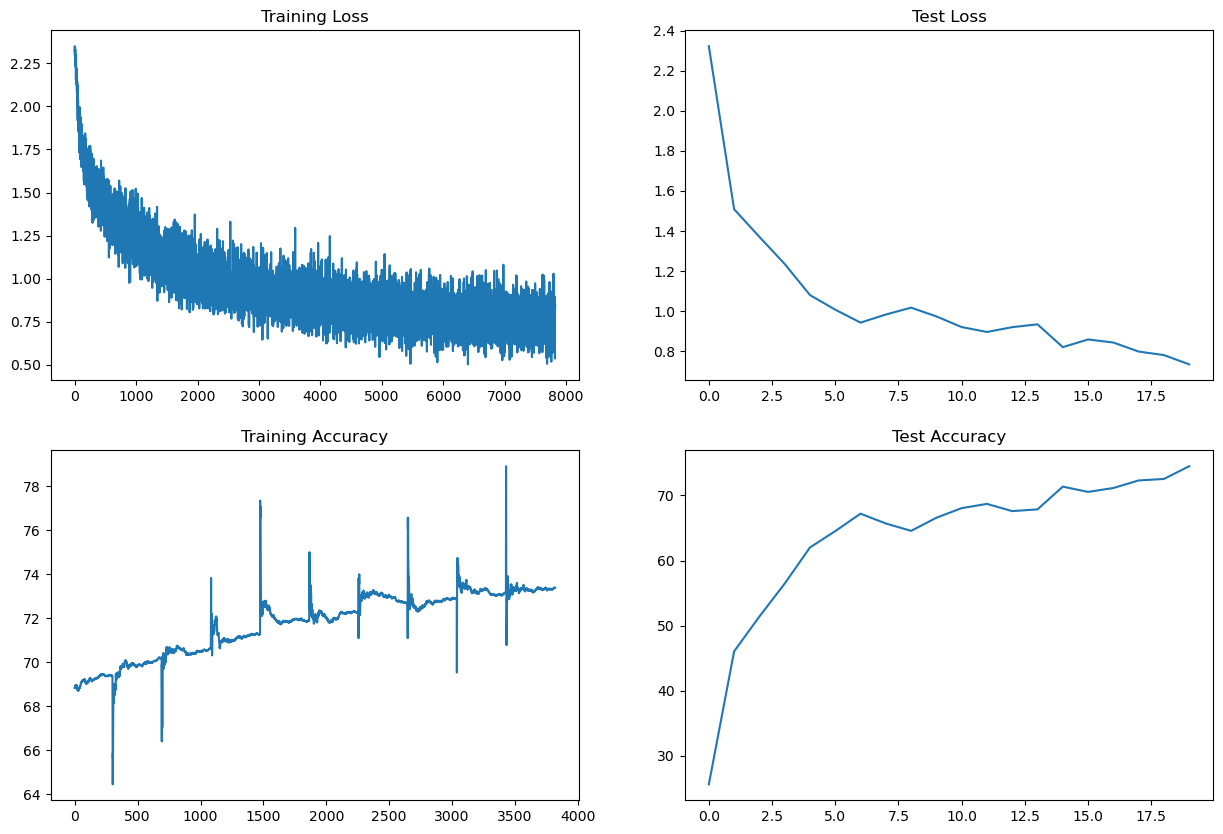

In [16]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Misclassified Images from CIFAR10 classifier

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


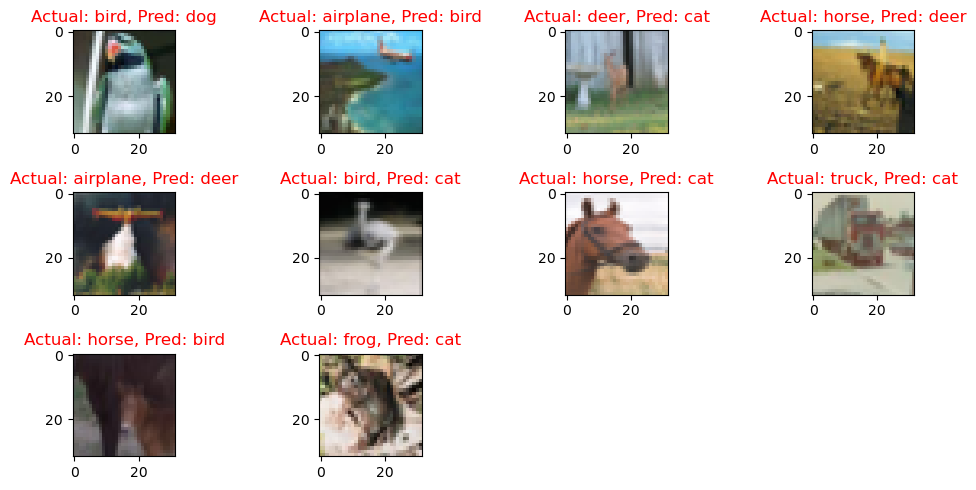

In [17]:
# define a function to plot misclassified images
import numpy as np
import matplotlib.pyplot as plt

def unnormalize(img):
    channel_means = (0.4914, 0.4822, 0.4471)
    channel_stdevs = (0.2469, 0.2433, 0.2615)
    img = img.numpy().astype(dtype=np.float32)
  
    for i in range(img.shape[0]):
         img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
    return np.transpose(img, (1,2,0))
    
def plot_misclassified_images(model, test_loader, classes, device):
    # set model to evaluation mode
    model.eval()

    misclassified_images = []
    actual_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    misclassified_images.append(data[i])
                    actual_labels.append(classes[target[i]])
                    predicted_labels.append(classes[pred[i]])

    # Plot the misclassified images
    fig = plt.figure(figsize=(10, 5))
    for i in range(10):
        sub = fig.add_subplot(3, 4, i+1)
        npimg = unnormalize(misclassified_images[i].cpu())
        plt.imshow(npimg, cmap='gray', interpolation='none')
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()

device = torch.device("mps")
plot_misclassified_images(model, test_loader, test_data.classes, device)
